## TEXT DETECTION

In [21]:
# import modules
%matplotlib inline
import random
import pylab
import pandas as pd
import numpy as np
import cPickle as pkl
from PIL import Image
import matplotlib.pyplot as plt
from lasagne import layers
from lasagne.updates import nesterov_momentum
from theano.tensor.nnet import softmax
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator

### reading SVT

In [ ]:
from scipy.misc import imread as ims
img = ims('/home/faizy/workspace/project/project/datasets/svt/svt1/img/01_15.jpg')
img.shape

In [ ]:
pylab.imshow(img)
pylab.show()

In [ ]:
lst = []
for i in range(0, 800, 50):
    for j in range(0, 1280, 60):
        if not (i + 50 > 800 or j + 60 > 1280):
            lst.append(img[i:i+50, j:j+60, :])

In [ ]:
i = random.randrange(0, 336)
pylab.imshow(lst[i])

In [ ]:
from scipy.misc import imresize
new_lst = []
for i in lst:
    new_lst.append(imresize(i, (28, 28)))

In [ ]:
new_list = np.stack(new_lst)
new_list = new_list.dot([0.299, 0.587, 0.144])
new_list.shape
tester = new_list.reshape(336, 1, 28, 28)

In [ ]:
tester /= tester.std(axis = None)
tester -= tester.mean()
tester = tester.astype('float32')

In [ ]:
#TODO implement a chars74k trained network
preder = net.predict(tester)

### reading chars74k

In [ ]:
root = '/home/faizy/workspace/project/project/scripts'
data = pd.read_csv(root + '/LISTFILE.txt', sep = ' ', header = None)

In [ ]:
data.head()

In [ ]:
from sklearn.cross_validation import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data[0], data[1])

In [ ]:
train_x.head();test_y.head()

In [ ]:
root = '/home/faizy/workspace/project/project/datasets/English/'
from scipy.misc import imread as ims
img = ims(root + train_x[0])

In [ ]:
pylab.imshow(img)
pylab.show()

### Actual code

In [55]:
# extra functions
def unpickle(filer):
    f = open(filer, 'rb')
    d_dict = pkl.load(f)
    f.close()
    return d_dict

from sklearn.cross_validation import train_test_split

In [63]:
# load train_test set
# cifar
train_dict = unpickle('/home/faizy/workspace/cifar/cifar-10-batches-py/data_batch_1')
train2_images = train_dict['data'].astype('float32')
train2_y = np.zeros((10000, )).astype('int')
test_dict = unpickle('/home/faizy/workspace/cifar/cifar-10-batches-py/test_batch')
test2_images = test_dict['data'].astype('float32')

# chars74k
data = pd.read_csv('/home/faizy/workspace/project/project/scripts/LISTFILE.txt', sep = ' ', header = None)
root = '/home/faizy/workspace/project/project/datasets/English/'
data_x = np.zeros((7705, 1, 32, 32))
data_y = np.ones((7705, )).astype('int32')
from scipy.misc import imread, imresize
for idx, path in enumerate(data[0]):
    img = imread(root + path)
    img = imresize(img, (32, 32))
    if len(img.shape) == 3:
        data_x[idx, ...] = img.dot([0.299, 0.587, 0.144])
    else:
        data_x[idx, ...] = img
        
data_x = data_x.astype('float32')
train1_x, test1_x, train1_y, test1_y = train_test_split(data_x, data_y, test_size = 0.2)

In [62]:
train_x.shape, test_x.shape

((6164, 1, 32, 32), (1541, 1, 32, 32))

In [65]:
# preprocess
# cifar
train2_images /= train2_images.std(axis = None)
train2_images -= train2_images.mean()

test2_images /= test2_images.std(axis = None)
test2_images -= test2_images.mean()

# chars74k
train1_x /= train1_x.std(axis = None)
train1_x -= train1_x.mean()

test1_x /= test1_x.std(axis = None)
test1_x -= test1_x.mean()

In [67]:
# reshape dataset
# cifar
# grayscaling and cropping to size
train2_x_rgb = train2_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

train2_x = np.zeros((10000, 1, 32, 32))
for i in range(10000):
    train2_x[i, :, :, :] = np.dot(train2_x_rgb[i, :, :, :], [0.299, 0.587, 0.144])

test2_x_rgb = test2_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

test2_x = np.zeros((10000, 1, 32, 32))
for i in range(10000):
    test2_x[i, :, :, :] = np.dot(test2_x_rgb[i, :, :, :], [0.299, 0.587, 0.144])

In [69]:
# finally
train_x = np.vstack((train1_x, train2_x))

train_y = np.concatenate([train1_y, train2_y])

test_x = np.vstack((test1_x, test2_x))

#TODO shuffle train-test

In [70]:
# check again
train_x = train_x.astype('float32')
train_y = train_y.astype('int32')
test_x = test_x.astype('float32')
test_y = test_y.astype('int32')

In [88]:
# setting nn 
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer),
    ],

    input_shape = (None, 1, 32, 32),
    conv1_num_filters = 32, conv1_filter_size = (3, 3),
    pool1_pool_size = (2, 2),
    dropout1_p = 0.2,
    conv2_num_filters = 64, conv2_filter_size = (2, 2),
    pool2_pool_size = (2, 2),
    dropout2_p = 0.2,
    hidden3_num_units = 100,
    output_num_units = 2, output_nonlinearity = softmax,

    batch_iterator_train = BatchIterator(batch_size = 1000),
    batch_iterator_test = BatchIterator(batch_size = 1000),

    update=nesterov_momentum,
    update_learning_rate = 0.003,
    update_momentum = 0.9,

    use_label_encoder = True,
    regression = False,
    max_epochs = 50,
    verbose = 1,
)

In [89]:
# train and test nn
net.fit(train_x, train_y)
pred = net.predict(test_x)

# Neural Network with 322478 learnable parameters

## Layer information

  #  name      size
---  --------  --------
  0  input     1x32x32
  1  conv1     32x30x30
  2  pool1     32x15x15
  3  dropout1  32x15x15
  4  conv2     64x14x14
  5  pool2     64x7x7
  6  dropout2  64x7x7
  7  hidden3   100
  8  output    2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       0.83033       0.63956      1.29828      0.69175  8.21s
      2       0.67893       0.62876      1.07980      0.69175  8.00s
      3       0.68432       0.62903      1.08791      0.69175  8.01s
      4       0.67356       0.62648      1.07516      0.69175  8.56s
      5       0.66604       0.62184      1.07107      0.69175  9.29s
      6       0.66203       0.61650      1.07385      0.69175  8.70s
      7       0.65926       0.61157      1.07797      0.69175  8.11s
      8       0.65599       0.60655      1.08152      0.69175  8

--------------
It is NOT a character


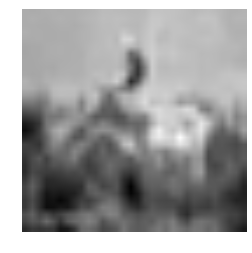

In [160]:
# visualize output
%matplotlib inline
i = random.randrange(1541, 11541)
img = test_x[i, :]
img = img.reshape(32, 32)
pylab.imshow(img)
pylab.gray()
pylab.axis('off')
print '--------------'
if pred[i] == 1:
    print "It is a character"
else:
    print "It is NOT a character"

--------------
It is a character


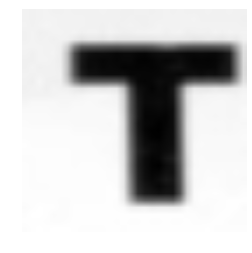

In [159]:
# visualize output
%matplotlib inline
i = random.randrange(0, 1541)
img = test_x[i, :]
img = img.reshape(32, 32)
pylab.imshow(img)
pylab.gray()
pylab.axis('off')
print '--------------'
if pred[i] == 1:
    print "It is a character"
else:
    print "It is NOT a character"

In [124]:
from sklearn.metrics import accuracy_score, classification_report

In [131]:
tester = np.concatenate([np.zeros((10000,)), test1_y])

In [130]:
print classification_report(tester, pred)

             precision    recall  f1-score   support

        0.0       0.85      0.82      0.84     10000
        1.0       0.05      0.06      0.05      1541

avg / total       0.74      0.72      0.73     11541



In [133]:
test_x.shape

(11541, 1, 32, 32)

In [154]:
test1_x.shape

(1541, 1, 32, 32)